# Objetivo
___

Detectar logo nas primeiras horas de internação se o paciente necessitará de internação em UTI.

A análise proposta nesse estudo é usar a primeira janela de dados e verificar se com os primeiros exames é possível prever se o paciente precisará de UTI, pra saber se o paciente necessitou de internação em UTI foram pegos os dados da última janela "ICU" que diz se o paciente foi internado ou não.

# Importações

In [1]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
path = 'https://raw.githubusercontent.com/Ederson-Branco/Data_Science/main/Datasets/covid_19_sirio_libanes.csv'
dados_raw = pd.read_csv(path,sep=';')

# Tratamento dos dados

In [3]:
dados_raw.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"0,086419753","-0,230769231","-0,283018868","-0,593220339","-0,285714286","0,736842105","0,086419753","-0,230769231","-0,283018868","-0,586206897","-0,285714286","0,736842105","0,237113402",0,"-0,162393162","-0,5","0,208791209","0,898989899","-0,247863248","-0,459459459","-0,432835821","-0,636363636","-0,420289855","0,736842105",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"0,333333333","-0,230769231","-0,132075472","-0,593220339","0,535714286","0,578947368","0,333333333","-0,230769231","-0,132075472","-0,586206897","0,535714286","0,578947368","0,443298969",0,"-0,025641026","-0,5","0,714285714","0,838383838","-0,076923077","-0,459459459","-0,313432836","-0,636363636","0,246376812","0,578947368",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939",...,"-0,994911922",-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"-0,107142857","0,736842105",NaN,NaN,NaN,NaN,"-0,107142857","0,736842105",NaN,NaN,NaN,NaN,"0,318681319","0,898989899",NaN,NaN,NaN,NaN,"-0,275362319","0,736842105",NaN,NaN,NaN,NaN,-1,-1,NaN,NaN,NaN,NaN,-1,-1,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,-1.0,"-0,871657754","-0,871657754","-0,871657754","-0,871657754",-1.0,"-0,863874346","-0,863874346","-0,863874346","-0,863874346",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,414634146","-0,414634146","-0,414634146","-0,414634146",-1.0,"-0,97906855","-0,97906855",...,"-0,996762132",-1.0,"-0,243021346","-0,338537325","-0,213030951","-0,31785923","0,033779029","0,665932072","-0,283950617","-0,376923077","-0,188679245","-0,379310345","0,035714286","0,6315

In [4]:
dados_raw.shape

(1925, 231)

In [5]:
dados_raw.isna().sum()

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64

Preenchimento dos valores nulos

In [6]:
'''
Utilizado o método "bfill" pois o "ffill" irá pegar os dados do paciente anterior 
quando a primeira janela possuir valores nulos 
'''

dados_raw.iloc[1919:1922][['PATIENT_VISIT_IDENTIFIER','ALBUMIN_MEDIAN']]

,PATIENT_VISIT_IDENTIFIER,ALBUMIN_MEDIAN
1919,383,"0,210526316"
1920,384,NaN
1921,384,"0,605263158"


In [7]:
dados_bfill = dados_raw.copy()
dados_bfill.fillna(method='bfill',inplace=True) 
dados_bfill.iloc[1919:1922][['PATIENT_VISIT_IDENTIFIER','ALBUMIN_MEDIAN']]

,PATIENT_VISIT_IDENTIFIER,ALBUMIN_MEDIAN
1919,383,"0,210526316"
1920,384,"0,605263158"
1921,384,"0,605263158"


Seleção dos dados, janela 0-2

In [8]:
dados = dados_bfill.query('WINDOW == "0-2"').reset_index().drop(columns='index')
dados

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939",...,"-0,994911922",-1.0,"0,086419753","-0,230769231","-0,283018868","-0,593220339","-0,285714286","0,736842105","0,086419753","-0,230769231","-0,283018868","-0,586206897","-0,285714286","0,736842105","0,237113402",0,"-0,162393162","-0,5","0,208791209","0,898989899","-0,247863248","-0,459459459","-0,432835821","-0,636363636","-0,420289855","0,736842105",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0-2,0
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"-0,210526316","-0,210526316","-0,210526316","-0,210526316",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,219512195","-0,219512195","-0,219512195","-0,219512195",-1.0,"-0,967556253","-0,967556253",...,"-0,978028755",-1.0,"-0,283950617","-0,046153846","0,188679245","0,830508475","-0,107142857",1,"-0,283950617","-0,046153846","0,188679245","0,862068966","-0,107142857",1,"-0,072164948","0,15","0,264957265",1,"0,318681319",1,"-0,504273504","-0,32972973","-0,059701493","0,636363636","-0,275362319",1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0-2,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939",...,"-0,978028755",-1.0,"-0,489711934","-0,685470085","-0,048218029","-0,645951036","0,357142857","0,935672515","-0,50617284","-0,815384615","-0,056603774","-0,517241379","0,357142857","0,947368421","-0,525773196","-0,5125","-0,111111111","-0,714285714","0,604395604","0,95959596","-0,435897436","-0,491891892",0,"-0,575757576","0,101449275",1,"-0,547826087","-0,533742331","-0,603053435","-0,764705882",-1,"-0,95959596","-0,51552795","-0,351327692","-0,747001091","-0,756272401",-1,"-0,961262106",0-2,0
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"-0,263157895","-0,263157895","-0,263157895","-0,263157895",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,972789116","-0,972789116",...,"-0,978028755",-1.0,"0,012

Seleção do target, onde a escolha foi o último dado por paciente do campo "ICU".

Conforme orientação do hospital Sírio-Líbanês os dados da janela "ABOVE_12" não devem ser usados no modelo, nesse caso foram pegos os dados da janela "6-12"

In [9]:
target = dados_raw.query('WINDOW == "6-12"')[['ICU']]
target = target.reset_index().drop(columns='index')
target

,ICU
0,0
1,1
2,0
3,0
4,0
...,...
380,0
381,0
382,0
383,0


In [10]:
frequencia = target.value_counts()
percentual = target.value_counts(normalize=True) * 100
dist_frequencia = pd.DataFrame({'Frequencia':frequencia,'Percentual (%)':percentual.round(2)})
dist_frequencia

,Frequencia,Percentual (%)
ICU,,
0,255,66.23
1,130,33.77


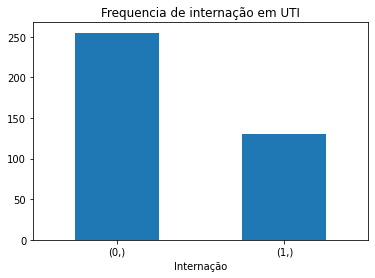

In [11]:
frequencia.plot(kind='bar')
plt.title('Frequencia de internação em UTI')
plt.xticks(rotation=0)
plt.xlabel('Internação')
plt.show()

In [12]:
dados = dados.drop(columns=['WINDOW','ICU','AGE_PERCENTIL'])
dados['target'] = target
dados.set_index('PATIENT_VISIT_IDENTIFIER',inplace=True,drop=True)
dados

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,target
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939","-0,938949939","-0,938949939",...,"-0,994911922","-0,994911922",-1.0,"0,086419753","-0,230769231","-0,283018868","-0,593220339","-0,285714286","0,736842105","0,086419753","-0,230769231","-0,283018868","-0,586206897","-0,285714286","0,736842105","0,237113402",0,"-0,162393162","-0,5","0,208791209","0,898989899","-0,247863248","-0,459459459","-0,432835821","-0,636363636","-0,420289855","0,736842105",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,"-0,210526316","-0,210526316","-0,210526316","-0,210526316",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,219512195","-0,219512195","-0,219512195","-0,219512195",-1.0,"-0,967556253","-0,967556253","-0,967556253","-0,967556253",...,"-0,978028755","-0,978028755",-1.0,"-0,283950617","-0,046153846","0,188679245","0,830508475","-0,107142857",1,"-0,283950617","-0,046153846","0,188679245","0,862068966","-0,107142857",1,"-0,072164948","0,15","0,264957265",1,"0,318681319",1,"-0,504273504","-0,32972973","-0,059701493","0,636363636","-0,275362319",1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"0,605263158","0,605263158","0,605263158","0,605263158",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,317073171","-0,317073171","-0,317073171","-0,317073171",-1.0,"-0,938949939","-0,938949939","-0,938949939","-0,938949939",...,"-0,978028755","-0,978028755",-1.0,"-0,489711934","-0,685470085","-0,048218029","-0,645951036","0,357142857","0,935672515","-0,50617284","-0,815384615","-0,056603774","-0,517241379","0,357142857","0,947368421","-0,525773196","-0,5125","-0,111111111","-0,714285714","0,604395604","0,95959596","-0,435897436","-0,491891892",0,"-0,575757576","0,101449275",1,"-0,547826087","-0,533742331","-0,603053435","-0,764705882",-1,"-0,95959596","-0,51552795","-0,351327692","-0,747001091","-0,756272401",-1,"-0,961262106",0
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"-0,263157895","-0,263157895","-0,263157895","-0,263157895",-1.0,-1,-1,-1,-1,-1.0,-1,-1,-1,

In [13]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Columns: 228 entries, AGE_ABOVE65 to target
dtypes: float64(45), int64(3), object(180)
memory usage: 688.8+ KB


convertendo object para float

In [14]:
selecao = dados.select_dtypes(include='object').columns

for i in selecao:
  dados[i] = dados[i].str.replace(',','.').astype(float)


dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Columns: 228 entries, AGE_ABOVE65 to target
dtypes: float64(225), int64(3)
memory usage: 688.8 KB


In [15]:
dados

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,target
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.210526,-0.210526,-0.210526,-0.210526,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.219512,-0.219512,-0.219512,-0.219512,-1.0,-0.967556,-0.967556,-0.967556,-0.967556,...,-0.978029,-0.978029,-1.0,-0.283951,-0.046154,0.188679,0.830508,-0.107143,1.000000,-0.283951,-0.046154,0.188679,0.862069,-0.107143,1.000000,-0.072165,0.1500,0.264957,1.000000,0.318681,1.000000,-0.504274,-0.329730,-0.059701,0.636364,-0.275362,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,-0.972789,...,-0.978029,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.44

# Separação dos dados para treino, teste e validação

In [16]:
X = dados.iloc[:300,0:-1]
y = dados['target'][0:300]
validacao = dados[300:]

# Seleção das features

Seleção automática através do feature_selection.RFECV

In [17]:
modelo = RandomForestClassifier(random_state=42,n_estimators=100)

In [18]:
treino_x, teste_x, treino_y, teste_y = train_test_split(X,y, random_state=42, test_size=0.3)

In [19]:
modelo.fit(treino_x,treino_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [20]:
# modelo + RFECV
selecionador = RFECV(estimator=modelo,cv=5,step=1, scoring='accuracy')

# .fit RFECV
selecionador.fit(treino_x,treino_y)
treino_rfecv = selecionador.transform(treino_x)
teste_rfecv = selecionador.transform(teste_x)

# .fit modelo
modelo.fit(treino_rfecv,treino_y)

# Score
modelo.score(teste_rfecv,teste_y)

0.7222222222222222

In [21]:
selecao = X.columns[selecionador.support_]

In [22]:
validacao = validacao[selecao]
dados = dados[selecao]

In [23]:
X.columns[selecionador.support_]

Index(['AGE_ABOVE65', 'GENDER', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
       'HTN', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN',
       'ALBUMIN_MAX',
       ...
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=158)

Colunas restantes após a seleção automática de features

In [24]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 384
Columns: 158 entries, AGE_ABOVE65 to OXYGEN_SATURATION_DIFF_REL
dtypes: float64(156), int64(2)
memory usage: 478.2 KB


In [25]:
X = dados.iloc[:300]

# Seleção do melhor modelo

In [26]:
X_treino,X_teste,y_treino,y_teste = train_test_split(X, y, random_state=42,test_size=0.3)

In [27]:
# Função para fazer o comparativo no resultado dos diferentes modelos

def verifica_acurácia(modelo):

  modelo.fit(X_treino,y_treino)
  predict = modelo.predict(X_teste)

  print(classification_report(y_teste,predict))

Para comparação foi utilizado um modelos svm, uma árvore de decisão e floresta aleatória
____

In [28]:
modelo_svm = SVC(random_state=42)
modelo_tree = DecisionTreeClassifier(random_state=42)
modelo_ensemble = RandomForestClassifier(random_state=42)

In [29]:
verifica_acurácia(modelo_tree)

              precision    recall  f1-score   support

           0       0.64      0.52      0.57        62
           1       0.25      0.36      0.29        28

    accuracy                           0.47        90
   macro avg       0.45      0.44      0.43        90
weighted avg       0.52      0.47      0.49        90



In [30]:
verifica_acurácia(modelo_svm)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        62
           1       0.46      0.43      0.44        28

    accuracy                           0.67        90
   macro avg       0.61      0.60      0.60        90
weighted avg       0.66      0.67      0.66        90



In [31]:
verifica_acurácia(modelo_ensemble)

              precision    recall  f1-score   support

           0       0.85      0.73      0.78        62
           1       0.54      0.71      0.62        28

    accuracy                           0.72        90
   macro avg       0.69      0.72      0.70        90
weighted avg       0.75      0.72      0.73        90



# Validação

In [32]:
validacao

,AGE_ABOVE65,GENDER,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,...,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300,0,1,0.0,0.0,0.0,1.0,0.842105,0.842105,0.842105,0.842105,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.981162,-0.981162,-0.981162,-0.981162,0.346939,0.346939,0.346939,0.346939,-0.906582,-0.906582,-0.906582,-0.906582,-0.744136,-0.744136,-0.744136,-0.744136,-0.991822,-0.991822,-0.991822,-0.991822,...,-0.879518,-0.879518,-0.879518,-0.982346,-0.982346,-0.982346,-0.982346,-0.407407,-0.846154,0.150943,-0.593220,0.178571,0.789474,-0.407407,-0.846154,0.150943,-0.586207,0.178571,0.789474,-0.175258,-0.500,0.230769,-0.500000,0.494505,0.919192,-0.589744,-0.891892,-0.089552,-0.636364,-0.043478,0.789474,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000
301,0,0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,0.357143,0.357143,0.357143,0.357143,-0.875442,-0.875442,-0.875442,-0.875442,-0.742004,-0.742004,-0.742004,-0.742004,-0.958528,-0.958528,-0.958528,-0.958528,...,-0.773494,-0.773494,-0.773494,-0.983502,-0.983502,-0.983502,-0.983502,0.012346,-0.415385,-0.132075,-0.593220,-0.178571,0.631579,0.012346,-0.415385,-0.132075,-0.586207,-0.178571,0.631579,0.175258,-0.150,-0.025641,-0.500000,0.274725,0.858586,-0.299145,-0.589189,-0.313433,-0.636364,-0.333333,0.631579,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000
302,0,0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.946625,-0.946625,-0.946625,-0.946625,0.357143,0.357143,0.357143,0.357143,-0.878273,-0.878273,-0.878273,-0.878273,-0.742004,-0.742004,-0.742004,-0.742004,-0.958528,-0.958528,-0.958528,-0.958528,...,-0.879518,-0.879518,-0.879518,-0.967698,-0.967698,-0.967698,-0.967698,-0.160494,-0.600000,-0.150943,-0.457627,-0.107143,0.789474,-0.160494,-0.600000,-0.150943,-0.448276,-0.107143,0.789474,0.030928,-0.300,-0.042735,-0.357143,0.318681,0.919192,-0.418803,-0.718919,-0.328358,-0.515152,-0.275362,0.789474,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000
303,0,1,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,0.357143,0.357143,0.357143,0.357143,-0.960368,-0.960368,-0.960368,-0.960368,-0.742004,-0.742004,-0.742004,-0.742004,-0.95852

In [33]:
target[300:]

,ICU
300,0
301,0
302,1
303,0
304,0
...,...
380,0
381,0
382,0
383,0


In [34]:
validacao_predict = modelo_ensemble.predict(validacao)

In [35]:
print(classification_report(target[300:],validacao_predict))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        61
           1       0.56      0.62      0.59        24

    accuracy                           0.75        85
   macro avg       0.70      0.71      0.71        85
weighted avg       0.76      0.75      0.76        85



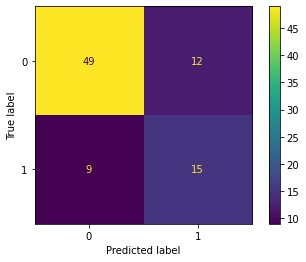

In [36]:
plot_confusion_matrix(modelo_ensemble,validacao,target[300:])

# Conclusão
____

Usando como base de estudo a primeira janela de internação e o último dado de ICU que nos diz se o paciente foi internado ou não,<br>
em conjunto com a função de seleção automática de features do scikit learn, obteve-se uma taxa de acerto de 75%.

Na minha opinião, por se tratar de pacientes, é necessário um novo estudo a fim de obter uma acurácia maior na predição de pacientes que necessitarão de internação em UTI